In [23]:
import pandas as pd
import numpy as np
import os
import glob
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 設置 logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =========================================
# 1. 排除特定的 ID
# =========================================

# 1.1 讀取 zero_diet_ids.csv
zero_ids_path = 'zero_diet_ids.csv'
if os.path.exists(zero_ids_path):
    zero_ids_df = pd.read_csv(zero_ids_path)
    zero_ids = set(zero_ids_df['ID'].astype(str).tolist())
    logging.info(f'讀取到 {len(zero_ids)} 個 zero_diet ID')
else:
    zero_ids = set()
    logging.warning(f'未找到 {zero_ids_path}，將不排除任何 zero_diet ID')

# 1.2 讀取 only_one_food_ids_with_serving 目錄下的所有 CSV 檔案並提取 ID
only_one_food_folder = 'only_one_food_ids_with_serving'
only_one_ids = set()

if os.path.exists(only_one_food_folder):
    csv_files = glob.glob(os.path.join(only_one_food_folder, '*.csv'))
    for file in csv_files:
        df = pd.read_csv(file)
        ids = df['ID'].astype(str).tolist()
        only_one_ids.update(ids)
    logging.info(f'讀取到 {len(only_one_ids)} 個 only_one_food ID')
else:
    logging.warning(f'未找到資料夾 {only_one_food_folder}，將不排除任何 only_one_food ID')

# 1.3 合併所有需要排除的 ID
excluded_ids = zero_ids.union(only_one_ids)
logging.info(f'總共需要排除的 ID 數量：{len(excluded_ids)}')

# 1.4 讀取資料集並排除指定的 ID
logging.info('讀取資料集')
data = pd.read_csv('diet_data.csv')
logging.info(f'資料集包含 {data.shape[0]} 筆樣本和 {data.shape[1]} 個特徵')

# 確保 'ID' 欄位存在
if 'ID' not in data.columns:
    logging.error("'ID' 欄位不存在於資料集中。")
    raise ValueError("'ID' 欄位不存在於資料集中。")

# 將 'ID' 欄位轉為字串類型以確保匹配
data['ID'] = data['ID'].astype(str)

# 排除指定的 ID
initial_count = data.shape[0]
data = data[~data['ID'].isin(excluded_ids)].reset_index(drop=True)
excluded_count = initial_count - data.shape[0]
logging.info(f'已排除 {excluded_count} 筆資料，剩餘 {data.shape[0]} 筆資料')

2024-11-26 12:06:56,614 - INFO - 讀取到 3005 個 zero_diet ID


2024-11-26 12:06:56,649 - INFO - 讀取到 4386 個 only_one_food ID
2024-11-26 12:06:56,650 - INFO - 總共需要排除的 ID 數量：7391
2024-11-26 12:06:56,651 - INFO - 讀取資料集
2024-11-26 12:06:56,710 - INFO - 資料集包含 56281 筆樣本和 54 個特徵
2024-11-26 12:06:56,732 - INFO - 已排除 7391 筆資料，剩餘 48890 筆資料


In [24]:
data.head()

,ID,Stewed,Prune,Dried,Mixed,Apple,Banana,Berry,Cherry,Grapefruit,...,Pea,Sweetpepper,Spinach,Sprouts,Sweetcorn,Freshtomato,Tinnedtomato,Turnip_swede,Watercress,Othervegetables
0,1000054,NaN,NaN,NaN,NaN,NaN,1.0,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2,1000208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
3,1000259,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000267,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.5


In [25]:
# =========================================
# 2. 處理缺失值與移除稀疏特徵
# =========================================

# 2.1 處理缺失值
# 將缺失值填充為零
data_filled = data.fillna(0)
logging.info('已將缺失值填充為零')

# 2.2 計算數據稀疏性
# 提取特徵列（排除 ID 列）
X = data_filled.iloc[:, 1:]
sparsity = 1.0 - (np.count_nonzero(X) / float(X.size))
logging.info(f"數據集的稀疏性：{sparsity * 100:.2f}%")

2024-11-26 12:07:06,089 - INFO - 已將缺失值填充為零
2024-11-26 12:07:06,101 - INFO - 數據集的稀疏性：88.20%


In [26]:
# =========================================
# 3. 刪除高稀疏性的特徵（食物項目）
# =========================================

# 計算每列非零元素的比例
nonzero_ratio = (X != 0).mean()
# 保留非零比例大於 5% 的列
selected_features = nonzero_ratio[nonzero_ratio > 0.05].index
# 獲取被刪除的特徵名稱
deleted_features = nonzero_ratio[nonzero_ratio <= 0.05].index.tolist()
logging.info(f"被刪除的特徵（非零比例 <= 5%）：{deleted_features}")

# 保留選定的特徵
data_filled = data_filled[['ID'] + list(selected_features)]
logging.info(f"保留 {len(selected_features)} 個特徵後的資料集形狀：{data_filled.shape}")

# 更新特徵資料
X = data_filled.iloc[:, 1:]

2024-11-26 12:07:11,416 - INFO - 被刪除的特徵（非零比例 <= 5%）：['Prune', 'Mixed', 'Cherry', 'Grapefruit', 'Mango', 'Melon', 'Pineapple', 'Other', 'Avocado', 'Broadbean', 'Butternutsquash', 'Leek', 'Parsnip', 'Sprouts', 'Turnip_swede', 'Watercress']
2024-11-26 12:07:11,420 - INFO - 保留 37 個特徵後的資料集形狀：(48890, 38)


In [27]:
# =========================================
# 4. 刪除所有特徵值為零的受試者
# =========================================

# 計算每行特徵值的總和
row_sums = X.sum(axis=1)
# 保留特徵值總和大於 0 的行
non_zero_row_mask = row_sums > 0
initial_participant_count = data_filled.shape[0]
data_filled = data_filled.loc[non_zero_row_mask].reset_index(drop=True)
removed_participants = initial_participant_count - data_filled.shape[0]
logging.info(f'已移除 {removed_participants} 筆全為零的受試者，剩餘 {data_filled.shape[0]} 筆資料')

# 更新特徵資料
X = data_filled.iloc[:, 1:]
logging.info(f"更新後的特徵資料形狀：{X.shape}")

2024-11-26 12:07:17,408 - INFO - 已移除 42 筆全為零的受試者，剩餘 48848 筆資料
2024-11-26 12:07:17,410 - INFO - 更新後的特徵資料形狀：(48848, 37)


In [28]:
from sklearn.preprocessing import StandardScaler
# =========================================
# 5. 資料標準化
# =========================================

# 應用 Z 分數標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
logging.info('已完成 Z 分數標準化')

2024-11-26 12:07:19,632 - INFO - 已完成 Z 分數標準化


In [63]:
# =========================================
# 6. UMAP 降維
# =========================================

n_components = 2  # 降維後的維度
min_dist = 0.005  # 可根據需要調整
n_neighbors = 18  # 固定 n_neighbors
umap_reducer = umap.UMAP(
    n_components=n_components,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    random_state=42,
    metric='euclidean',
    verbose=True
)

# 執行 UMAP 降維
X_umap = umap_reducer.fit_transform(X_scaled)
logging.info(f"UMAP 降維後的形狀：{X_umap.shape}")

/usr2/kevin/anaconda3/envs/diet_data_clustering_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.005, n_jobs=1, n_neighbors=18, random_state=42, verbose=True)
Tue Nov 26 12:59:45 2024 Construct fuzzy simplicial set
Tue Nov 26 12:59:45 2024 Finding Nearest Neighbors
Tue Nov 26 12:59:45 2024 Building RP forest with 16 trees
Tue Nov 26 12:59:45 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Tue Nov 26 12:59:47 2024 Finished Nearest Neighbor Search
Tue Nov 26 12:59:47 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs


2024-11-26 13:00:15,878 - INFO - UMAP 降維後的形狀：(48848, 2)


	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 26 13:00:15 2024 Finished embedding


2024-11-26 13:00:16,036 - INFO - 繪製 UMAP 降維結果


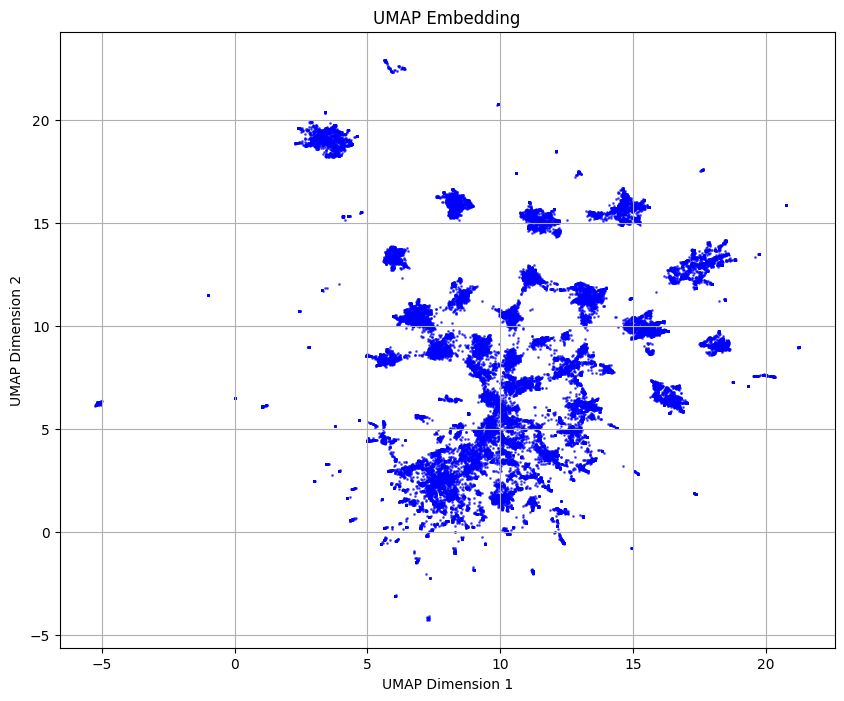

In [64]:
# 繪製 UMAP 降維結果
logging.info('繪製 UMAP 降維結果')
plt.figure(figsize=(10, 8))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1], 
    c='blue',  # 顏色
    alpha=0.6,  # 點的透明度
    s=1  # 點的大小
)
plt.title('UMAP Embedding')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()


In [65]:
# =========================================
# 7. DBSCAN 聚類
# =========================================

eps_list = [1.0]  # 修改為您指定的 eps 值列表

best_sil_score = -1
best_eps_value = None
best_labels = None
best_X_umap = None

silhouette_scores = []
non_noise_points_list = []

for eps_value in eps_list:
    # 執行 DBSCAN 聚類
    dbscan = DBSCAN(eps=eps_value, min_samples=10)
    labels = dbscan.fit_predict(X_umap)

    # 計算生成的群組數量
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_non_noise_points = np.count_nonzero(labels != -1)
    logging.info(f"DBSCAN 聚類結果（eps={eps_value}）：")
    logging.info(f"生成的群組數量：{n_clusters}")
    logging.info(f"非噪音點的數量：{num_non_noise_points}")

    # 儲存非噪音點的數量
    non_noise_points_list.append(num_non_noise_points)

    # 計算 Silhouette Score（排除噪音點）
    if n_clusters > 1 and num_non_noise_points > 1:
        sil_score = silhouette_score(X_umap[labels != -1], labels[labels != -1])
        logging.info(f"聚類的 Silhouette Score：{sil_score}")
        silhouette_scores.append(sil_score)
    else:
        sil_score = -1
        silhouette_scores.append(sil_score)
        logging.warning("無法計算 Silhouette Score，因為群組數量少於 2 或沒有足夠的非噪音點。")

    # 保存最佳結果
    if sil_score > best_sil_score:
        best_sil_score = sil_score
        best_eps_value = eps_value
        best_labels = labels.copy()
        best_X_umap = X_umap.copy()

logging.info(f"\n最佳的 eps 值為：{best_eps_value}，對應的 Silhouette Score：{best_sil_score}")

# 使用最佳的 eps 值進行後續分析
labels = best_labels
X_umap = best_X_umap
data_filled['Cluster'] = labels

2024-11-26 13:00:31,350 - INFO - DBSCAN 聚類結果（eps=1.0）：
2024-11-26 13:00:31,351 - INFO - 生成的群組數量：30
2024-11-26 13:00:31,351 - INFO - 非噪音點的數量：48848
2024-11-26 13:01:00,723 - INFO - 聚類的 Silhouette Score：0.011416247114539146
2024-11-26 13:01:00,724 - INFO - 
最佳的 eps 值為：1.0，對應的 Silhouette Score：0.011416247114539146


In [66]:
# =========================================
# 8. 生成聚類細節
# =========================================

# 8.1 計算每個群組的樣本數量
cluster_counts = data_filled['Cluster'].value_counts().sort_index()
logging.info("\n每個群組的樣本數量（-1 表示噪音點）：")
logging.info(cluster_counts)

# 8.2 計算每個群組的特徵平均值和標準差（排除噪音點）
# 在計算平均值和標準差前，移除 'ID' 列
data_for_stats = data_filled.drop(columns=['ID'])
# cluster_profiles_mean = data_for_stats[data_for_stats['Cluster'] != -1].groupby('Cluster').mean()
# cluster_profiles_std = data_for_stats[data_for_stats['Cluster'] != -1].groupby('Cluster').std()

# 將平均值和標準差保留到小數點後一位
# cluster_profiles_mean = cluster_profiles_mean.round(1)
# cluster_profiles_std = cluster_profiles_std.round(1)

# 9. 生成每個群組的 CSV 文件（不包括噪音點），保留 'ID' 列
unique_clusters = data_filled['Cluster'].unique()
for cluster_label in unique_clusters:
    if cluster_label != -1:  # 排除噪音點
        cluster_data = data_filled[data_filled['Cluster'] == cluster_label]
        # 保留 'ID' 列
        filename = f'cluster_{cluster_label}.csv'
        cluster_data.to_csv(filename, index=False)
        logging.info(f"已生成群組 {cluster_label} 的 CSV 文件：{filename}")

# 10. 將群組特徵平均值和標準差保存為 CSV 文件（移除 'ID' 列）
# cluster_profiles_mean.to_csv('cluster_feature_averages.csv')
# cluster_profiles_std.to_csv('cluster_feature_stddev.csv')
logging.info("已將群組特徵平均值保存為 'cluster_feature_averages.csv'")
logging.info("已將群組特徵標準差保存為 'cluster_feature_stddev.csv'")

2024-11-26 13:01:00,737 - INFO - 
每個群組的樣本數量（-1 表示噪音點）：
2024-11-26 13:01:00,738 - INFO - Cluster
0      1584
1      2059
2     34441
3      3886
4      1694
5       100
6      1311
7        33
8       536
9       248
10       65
11      300
12     1312
13      107
14       61
15       65
16       51
17      287
18      100
19       35
20      146
21       56
22       43
23      110
24       68
25       41
26       24
27       54
28       20
29       11
Name: count, dtype: int64
2024-11-26 13:01:00,760 - INFO - 已生成群組 0 的 CSV 文件：cluster_0.csv
2024-11-26 13:01:00,785 - INFO - 已生成群組 1 的 CSV 文件：cluster_1.csv
2024-11-26 13:01:01,105 - INFO - 已生成群組 2 的 CSV 文件：cluster_2.csv
2024-11-26 13:01:01,145 - INFO - 已生成群組 3 的 CSV 文件：cluster_3.csv
2024-11-26 13:01:01,163 - INFO - 已生成群組 4 的 CSV 文件：cluster_4.csv
2024-11-26 13:01:01,166 - INFO - 已生成群組 5 的 CSV 文件：cluster_5.csv
2024-11-26 13:01:01,181 - INFO - 已生成群組 6 的 CSV 文件：cluster_6.csv
2024-11-26 13:01:01,182 - INFO - 已生成群組 7 的 CSV 文件：cluster_7.csv
2024-1

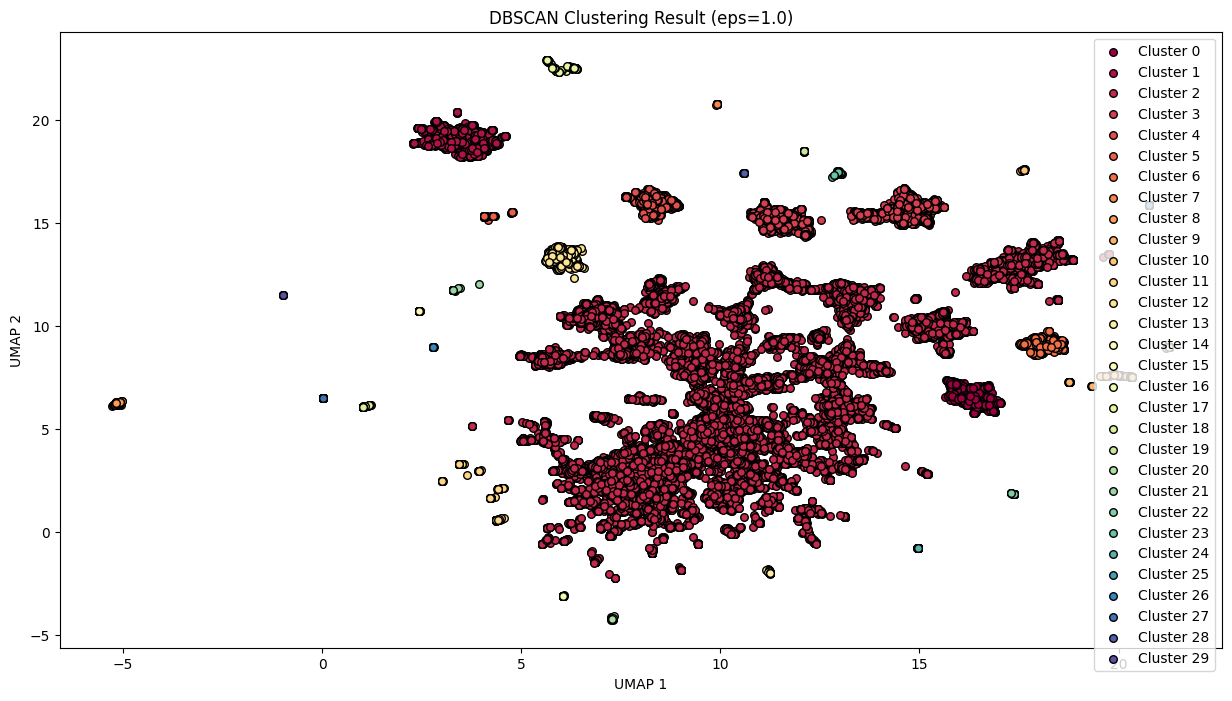

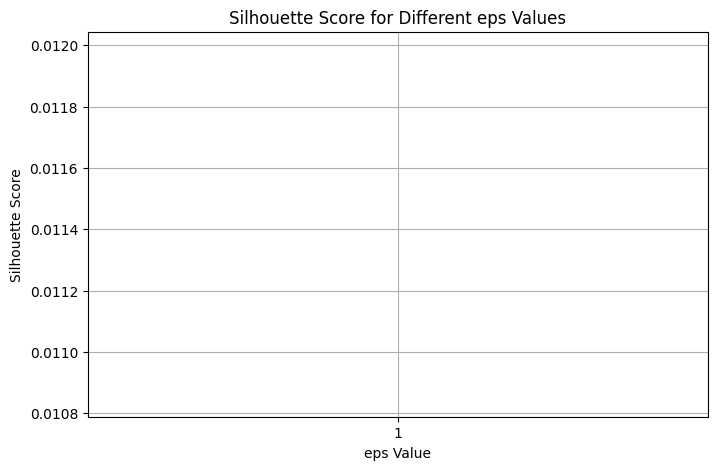

In [67]:
# =========================================
# 11. 可視化聚類結果
# =========================================

# 使用 UMAP 降維後的資料繪製散點圖
plt.figure(figsize=(15, 8))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # 噪音點顏色設為黑色
        col = 'black'
        label_name = 'Noise'
    else:
        label_name = f'Cluster {k}'
    
    xy = X_umap[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=label_name, edgecolors='k', s=30)

plt.title(f'DBSCAN Clustering Result (eps={best_eps_value})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

# 12. 繪製 Silhouette Score 曲線
plt.figure(figsize=(8, 5))
plt.plot(eps_list, silhouette_scores)
plt.title('Silhouette Score for Different eps Values')
plt.xlabel('eps Value')
plt.ylabel('Silhouette Score')
plt.xticks(eps_list)
plt.grid(True)
plt.show()
